In [1]:
# PROYECTO COMPLETO: CREDIT SCORING & PRICING MODEL
# Integra análisis exploratorio, modelos de scoring y pricing

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report, 
    confusion_matrix, roc_curve
)
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", palette="crest")

In [13]:
# ===============================================================
# FASE 1: CARGA Y PREPARACIÓN DE DATOS
# ===============================================================

# Cargar datos
df = pd.read_csv("train.csv")
print(f"\n✓ Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas")
print("\nTipos de datos:")
print(df.dtypes.value_counts())

# Eliminar columnas irrelevantes
drop_cols = ["ID", "Customer_ID", "Name", "SSN", "Type_of_Loan", "Month"]
df.drop(columns=drop_cols, inplace=True, errors="ignore")

# Convertir variable objetivo a numérica
df["Credit_Score"] = df["Credit_Score"].replace({"Poor": 0, "Standard": 1, "Good": 2})

# Codificar variables categóricas
le = LabelEncoder()
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

print(f"\n✓ Variables categóricas codificadas: {len(cat_cols)} columnas")
print("\nPrimeras 3 filas:")
print(df.head(3))


✓ Datos cargados: 100000 filas, 28 columnas

Tipos de datos:
float64    18
object      7
int64       3
Name: count, dtype: int64

✓ Variables categóricas codificadas: 4 columnas

Primeras 3 filas:
    Age  Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0  23.0          12       19114.12            1824.843333                3.0   
1  23.0          12       19114.12            1824.843333                3.0   
2  23.0          12       19114.12            1824.843333                3.0   

   Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
0              4.0            3.0          4.0                  3.0   
1              4.0            3.0          4.0                  3.0   
2              4.0            3.0          4.0                  3.0   

   Num_of_Delayed_Payment  ...  Credit_Mix  Outstanding_Debt  \
0                     7.0  ...           1            809.98   
1                     4.0  ...           1            809.98   
2   

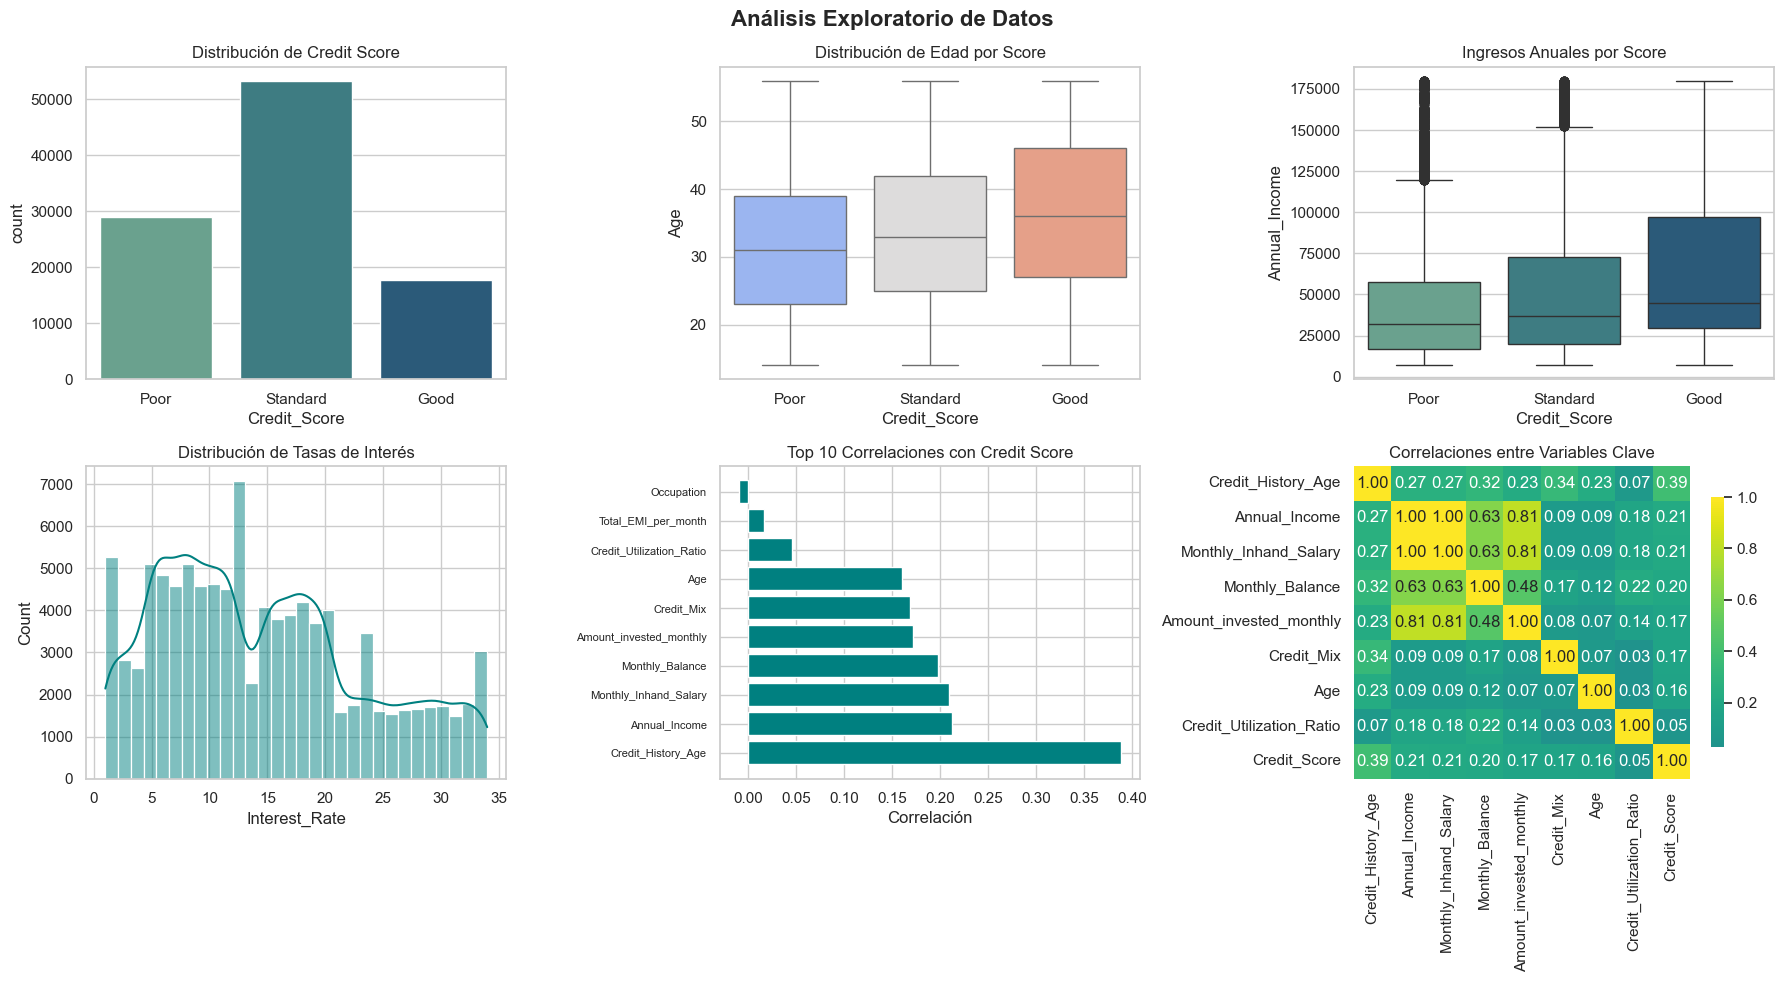

In [6]:
# ===============================================================
# FASE 2: ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ===============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Análisis Exploratorio de Datos', fontsize=16, fontweight='bold')

# 1. Distribución de Credit Score
sns.countplot(x="Credit_Score", data=df, palette="crest", ax=axes[0, 0])
axes[0, 0].set_title("Distribución de Credit Score")
axes[0, 0].set_xticklabels(['Poor', 'Standard', 'Good'])

# 2. Edad vs Score
sns.boxplot(x="Credit_Score", y="Age", data=df, palette="coolwarm", ax=axes[0, 1])
axes[0, 1].set_title("Distribución de Edad por Score")
axes[0, 1].set_xticklabels(['Poor', 'Standard', 'Good'])

# 3. Ingresos vs Score
sns.boxplot(x="Credit_Score", y="Annual_Income", data=df, palette="crest", ax=axes[0, 2])
axes[0, 2].set_title("Ingresos Anuales por Score")
axes[0, 2].set_xticklabels(['Poor', 'Standard', 'Good'])

# 4. Distribución de tasas de interés
sns.histplot(df["Interest_Rate"], bins=30, kde=True, color="teal", ax=axes[1, 0])
axes[1, 0].set_title("Distribución de Tasas de Interés")

# 5. Correlación con Credit Score
correlations = df.corr(numeric_only=True)["Credit_Score"].sort_values(ascending=False)[1:11]
axes[1, 1].barh(range(len(correlations)), correlations.values, color='teal')
axes[1, 1].set_yticks(range(len(correlations)))
axes[1, 1].set_yticklabels(correlations.index, fontsize=8)
axes[1, 1].set_title("Top 10 Correlaciones con Credit Score")
axes[1, 1].set_xlabel("Correlación")

# 6. Mapa de calor de correlaciones (top variables)
top_corr_vars = correlations.head(8).index.tolist() + ['Credit_Score']
sns.heatmap(df[top_corr_vars].corr(), annot=True, fmt='.2f', 
            cmap="viridis", center=0, ax=axes[1, 2], cbar_kws={'shrink': 0.8})
axes[1, 2].set_title("Correlaciones entre Variables Clave")

plt.tight_layout()
plt.show()




✓ División de datos:
   - Training: 80000 muestras
   - Testing: 20000 muestras
   - Distribución train: [23198 56802]
   - Distribución test: [ 5800 14200]

[1/2] Entrenando Regresión Logística...

   RESULTADOS - LOGISTIC REGRESSION
   Train Accuracy: 0.7866
   Test Accuracy : 0.7847
   Test AUC-ROC  : 0.8088

[2/2] Entrenando Random Forest...

   RESULTADOS - RANDOM FOREST
   Train Accuracy: 0.8462
   Test Accuracy : 0.8398
   Test AUC-ROC  : 0.8893


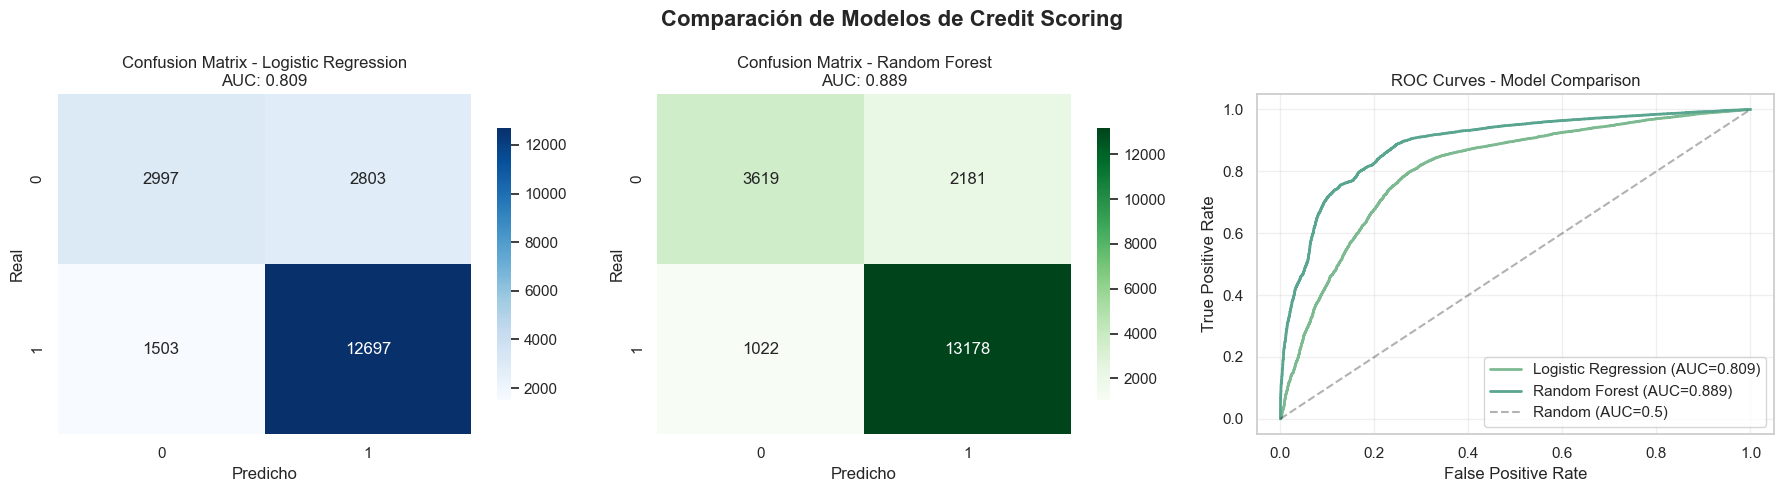

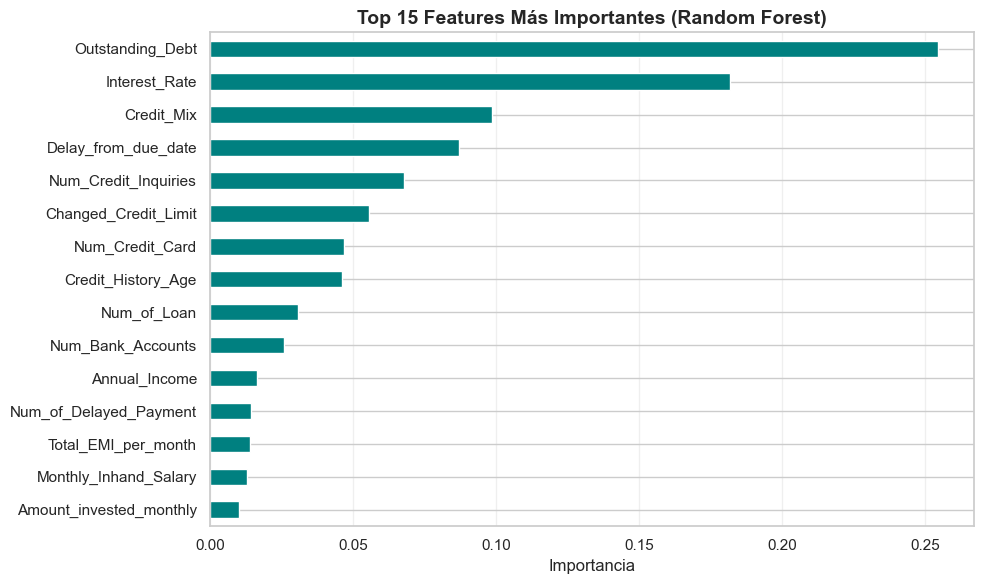

In [14]:
# ===============================================================
# FASE 3: ENTRENAMIENTO Y COMPARACIÓN DE MODELOS
# ===============================================================

# Preparar datos para modelado
X = df.drop(columns=["Credit_Score"])
y = df["Credit_Score"]

# Convertir a problema binario para PD: 0=Poor (Default), 1=Standard/Good (No Default)
y_binary = np.where(y == 0, 0, 1)

# Escalar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"\n✓ División de datos:")
print(f"   - Training: {X_train.shape[0]} muestras")
print(f"   - Testing: {X_test.shape[0]} muestras")
print(f"   - Distribución train: {np.bincount(y_train)}")
print(f"   - Distribución test: {np.bincount(y_test)}")

# ---- MODELO 1: REGRESIÓN LOGÍSTICA ----
print("\n[1/2] Entrenando Regresión Logística...")
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_pred_log_prob = log_model.predict_proba(X_test)[:,1]

acc_log = accuracy_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, y_pred_log_prob)

print(f"\n   RESULTADOS - LOGISTIC REGRESSION")
print(f"   Train Accuracy: {log_model.score(X_train, y_train):.4f}")
print(f"   Test Accuracy : {acc_log:.4f}")
print(f"   Test AUC-ROC  : {auc_log:.4f}")

# ---- MODELO 2: RANDOM FOREST ----
print("\n[2/2] Entrenando Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=300, 
    max_depth=10, 
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_pred_rf_prob = rf_model.predict_proba(X_test)[:,1]

acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf_prob)

print(f"\n   RESULTADOS - RANDOM FOREST")
print(f"   Train Accuracy: {rf_model.score(X_train, y_train):.4f}")
print(f"   Test Accuracy : {acc_rf:.4f}")
print(f"   Test AUC-ROC  : {auc_rf:.4f}")

# ---- COMPARACIÓN VISUAL ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Comparación de Modelos de Credit Scoring', fontsize=16, fontweight='bold')

# Matrices de confusión
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt="d", 
            cmap="Blues", ax=axes[0], cbar_kws={'shrink': 0.8})
axes[0].set_title(f"Confusion Matrix - Logistic Regression\nAUC: {auc_log:.3f}")
axes[0].set_ylabel("Real")
axes[0].set_xlabel("Predicho")

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", 
            cmap="Greens", ax=axes[1], cbar_kws={'shrink': 0.8})
axes[1].set_title(f"Confusion Matrix - Random Forest\nAUC: {auc_rf:.3f}")
axes[1].set_ylabel("Real")
axes[1].set_xlabel("Predicho")

# Curvas ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_pred_log_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf_prob)

axes[2].plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC={auc_log:.3f})", linewidth=2)
axes[2].plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={auc_rf:.3f})", linewidth=2)
axes[2].plot([0,1], [0,1], 'k--', label="Random (AUC=0.5)", alpha=0.3)
axes[2].set_title("ROC Curves - Model Comparison")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---- FEATURE IMPORTANCE ----
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.head(15).sort_values().plot(kind='barh', color='teal')
plt.title("Top 15 Features Más Importantes (Random Forest)", fontsize=14, fontweight='bold')
plt.xlabel("Importancia")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()



[1/2] Ejecutando validación cruzada...

   Logistic Regression - AUC CV: 0.8077 ± 0.0039
   Random Forest       - AUC CV: 0.8886 ± 0.0035

[2/2] Optimizando hiperparámetros (Random Forest)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

   ✓ Mejores parámetros encontrados:
      - n_estimators: 200
      - min_samples_split: 2
      - min_samples_leaf: 1
      - max_depth: None

   RESULTADOS - RANDOM FOREST OPTIMIZADO
   Train Accuracy: 1.0000
   Test Accuracy : 0.8915
   Test AUC-ROC  : 0.9454


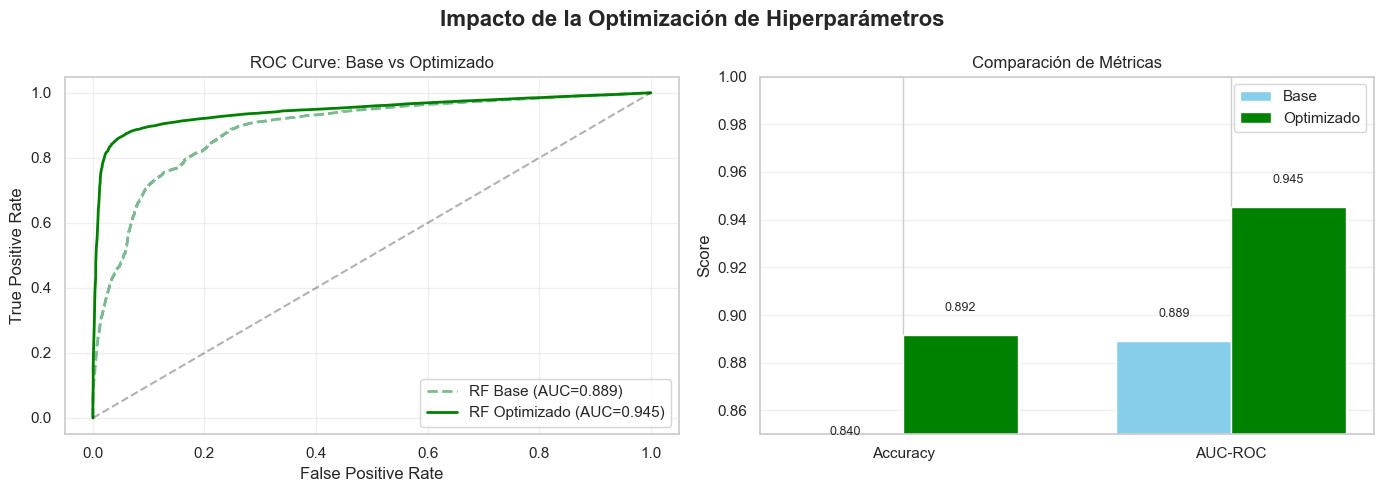


✓ Optimización completada - Usando modelo optimizado para pricing


In [8]:
# ===============================================================
# FASE 4: VALIDACIÓN CRUZADA Y OPTIMIZACIÓN
# ===============================================================

# Validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n[1/2] Ejecutando validación cruzada...")
cv_scores_log = cross_val_score(log_model, X_scaled, y_binary, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_rf = cross_val_score(rf_model, X_scaled, y_binary, cv=cv, scoring="roc_auc", n_jobs=-1)

print(f"\n   Logistic Regression - AUC CV: {cv_scores_log.mean():.4f} ± {cv_scores_log.std():.4f}")
print(f"   Random Forest       - AUC CV: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")

# Optimización de hiperparámetros
print("\n[2/2] Optimizando hiperparámetros (Random Forest)...")
param_dist = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [8, 10, 12, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rand_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rand_search.fit(X_train, y_train)

print(f"\n   ✓ Mejores parámetros encontrados:")
for param, value in rand_search.best_params_.items():
    print(f"      - {param}: {value}")

# Modelo optimizado
best_rf = rand_search.best_estimator_
y_pred_best = best_rf.predict(X_test)
y_pred_best_prob = best_rf.predict_proba(X_test)[:,1]

acc_best = accuracy_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_pred_best_prob)

print(f"\n   RESULTADOS - RANDOM FOREST OPTIMIZADO")
print(f"   Train Accuracy: {best_rf.score(X_train, y_train):.4f}")
print(f"   Test Accuracy : {acc_best:.4f}")
print(f"   Test AUC-ROC  : {auc_best:.4f}")

# Comparación visual antes/después optimización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Impacto de la Optimización de Hiperparámetros', fontsize=16, fontweight='bold')

# ROC Curves
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_rf_prob)
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_pred_best_prob)

axes[0].plot(fpr_base, tpr_base, label=f"RF Base (AUC={auc_rf:.3f})", 
             linestyle="--", linewidth=2)
axes[0].plot(fpr_opt, tpr_opt, label=f"RF Optimizado (AUC={auc_best:.3f})", 
             color="green", linewidth=2)
axes[0].plot([0,1],[0,1],'k--', alpha=0.3)
axes[0].set_title("ROC Curve: Base vs Optimizado")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Comparación de métricas
metrics = ['Accuracy', 'AUC-ROC']
base_scores = [acc_rf, auc_rf]
opt_scores = [acc_best, auc_best]

x = np.arange(len(metrics))
width = 0.35

axes[1].bar(x - width/2, base_scores, width, label='Base', color='skyblue')
axes[1].bar(x + width/2, opt_scores, width, label='Optimizado', color='green')
axes[1].set_ylabel('Score')
axes[1].set_title('Comparación de Métricas')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim([0.85, 1.0])
axes[1].grid(axis='y', alpha=0.3)

for i, (base, opt) in enumerate(zip(base_scores, opt_scores)):
    axes[1].text(i - width/2, base + 0.01, f'{base:.3f}', ha='center', fontsize=9)
    axes[1].text(i + width/2, opt + 0.01, f'{opt:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()


In [9]:
# ===============================================================
# FASE 5: COMPONENTES DE TASA DE INTERÉS
# ===============================================================

class InterestRateComponents:
    """Define los componentes fundamentales de la tasa de interés"""
    
    def __init__(self):
        self.base_rate = 0.1100          # 11.00% - Tasa Banxico
        self.inflation_premium = 0.0450  # 4.50%
        self.liquidity_premium = 0.0200  # 2.00%
        self.operational_costs = 0.0350  # 3.50%
        self.profit_margin = 0.0300      # 3.00%
    
    def get_base_components_rate(self):
        """Suma de componentes fijos (sin riesgo crediticio)"""
        return (self.base_rate + self.inflation_premium + 
                self.liquidity_premium + self.operational_costs + 
                self.profit_margin)
    
    def display_components(self):
        """Muestra desglose de componentes"""
        components = {
            'Tasa Base (Banco Central)': self.base_rate,
            'Prima por Inflación': self.inflation_premium,
            'Prima por Liquidez': self.liquidity_premium,
            'Costos Operativos': self.operational_costs,
            'Margen de Beneficio': self.profit_margin,
            'SUBTOTAL (sin riesgo crediticio)': self.get_base_components_rate()
        }
        
        df_comp = pd.DataFrame(list(components.items()), 
                               columns=['Componente', 'Tasa'])
        df_comp['Tasa (%)'] = df_comp['Tasa'] * 100
        return df_comp

# Inicializar componentes
rate_components = InterestRateComponents()

print("\n   COMPONENTES BASE DE LA TASA DE INTERÉS:")
print("   " + "-"*60)
components_df = rate_components.display_components()
for _, row in components_df.iterrows():
    print(f"   {row['Componente']:<35} {row['Tasa (%)']:>8.2f}%")
print("   " + "-"*60)


   COMPONENTES BASE DE LA TASA DE INTERÉS:
   ------------------------------------------------------------
   Tasa Base (Banco Central)              11.00%
   Prima por Inflación                     4.50%
   Prima por Liquidez                      2.00%
   Costos Operativos                       3.50%
   Margen de Beneficio                     3.00%
   SUBTOTAL (sin riesgo crediticio)       24.00%
   ------------------------------------------------------------


In [10]:
# ===============================================================
# FASE 6: CÁLCULO DE PARÁMETROS DE RIESGO (PD, LGD, EAD)
# ===============================================================

class CreditRiskParameters:
    """Calcula PD, LGD, EAD para la cartera"""
    
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        # Probabilidad de default (clase 0)
        self.proba_default = model.predict_proba(X_test)[:, 0]
    
    def calculate_pd(self):
        """Probability of Default"""
        pd_values = self.proba_default
        pd_portfolio = np.mean(pd_values)
        return pd_values, pd_portfolio
    
    def calculate_lgd(self, recovery_rate=0.35):
        """Loss Given Default - Para tarjetas sin garantía"""
        lgd = 1 - recovery_rate
        return lgd
    
    def calculate_ead(self, credit_limits):
        """Exposure at Default"""
        ccf = 0.75  # Credit Conversion Factor
        utilization_rate = 0.50
        ead_values = credit_limits * (utilization_rate + ccf * (1 - utilization_rate))
        return ead_values
    
    def calculate_expected_loss(self, pd, lgd, ead):
        """Expected Loss: EL = PD × LGD × EAD"""
        return pd * lgd * ead
    
    def get_risk_summary(self, credit_limits):
        """Genera resumen completo de riesgo"""
        pd_values, pd_portfolio = self.calculate_pd()
        lgd = self.calculate_lgd()
        ead_values = self.calculate_ead(credit_limits)
        el_values = self.calculate_expected_loss(pd_values, lgd, ead_values)
        
        return {
            'pd_values': pd_values,
            'pd_portfolio': pd_portfolio,
            'lgd': lgd,
            'ead_values': ead_values,
            'el_values': el_values,
            'el_portfolio': np.mean(el_values)
        }

# Calcular parámetros de riesgo
risk_params = CreditRiskParameters(best_rf, X_test, y_test)

# Simular límites de crédito
np.random.seed(42)
credit_limits = np.random.uniform(10000, 100000, size=len(X_test))

risk_data = risk_params.get_risk_summary(credit_limits)

print("\n   RESUMEN DE PARÁMETROS DE RIESGO:")
print("   " + "-"*60)
print(f"   PD Promedio (Cartera)         : {risk_data['pd_portfolio']:.2%}")
print(f"   LGD (Loss Given Default)      : {risk_data['lgd']:.2%}")
print(f"   EAD Promedio                  : ${np.mean(risk_data['ead_values']):,.2f}")
print(f"   Pérdida Esperada Promedio     : ${risk_data['el_portfolio']:,.2f}")
print(f"   Exposición Total (Cartera)    : ${np.sum(risk_data['ead_values']):,.2f}")
print("   " + "-"*60)


   RESUMEN DE PARÁMETROS DE RIESGO:
   ------------------------------------------------------------
   PD Promedio (Cartera)         : 29.38%
   LGD (Loss Given Default)      : 65.00%
   EAD Promedio                  : $48,073.40
   Pérdida Esperada Promedio     : $9,223.31
   Exposición Total (Cartera)    : $961,467,929.56
   ------------------------------------------------------------


In [12]:
# ===============================================================
# FASE 7: MODELO DE PRICING - DETERMINACIÓN DE TASAS
# ===============================================================


class CreditCardPricingModel:
    """Modelo de pricing que integra componentes y riesgo"""
    
    def __init__(self, rate_components, risk_data):
        self.components = rate_components
        self.risk_data = risk_data
    
    def calculate_credit_risk_premium(self, pd, lgd, risk_multiplier=2.5):
        """Prima por Riesgo = (PD × LGD) × Multiplicador"""
        return pd * lgd * risk_multiplier
    
    def calculate_interest_rate(self, pd_values, lgd):
        """Calcula tasa final personalizada"""
        base_rate = self.components.get_base_components_rate()
        credit_risk_premiums = self.calculate_credit_risk_premium(pd_values, lgd)
        final_rates = base_rate + credit_risk_premiums
        return final_rates, credit_risk_premiums
    
    def assign_rate_tier(self, final_rate):
        """Asigna tier según nivel de riesgo"""
        if final_rate < 0.30:
            return "Excelente (Tier 1)"
        elif final_rate < 0.45:
            return "Bueno (Tier 2)"
        elif final_rate < 0.60:
            return "Regular (Tier 3)"
        else:
            return "Alto Riesgo (Tier 4)"
    
    def generate_pricing_report(self):
        """Genera reporte completo de pricing"""
        pd_values = self.risk_data['pd_values']
        lgd = self.risk_data['lgd']
        ead_values = self.risk_data['ead_values']
        el_values = self.risk_data['el_values']
        
        final_rates, risk_premiums = self.calculate_interest_rate(pd_values, lgd)
        
        pricing_df = pd.DataFrame({
            'Cliente_ID': range(1, len(pd_values) + 1),
            'PD': pd_values,
            'LGD': lgd,
            'EAD': ead_values,
            'Pérdida_Esperada': el_values,
            'Prima_Riesgo': risk_premiums,
            'Tasa_Interés_Anual': final_rates,
            'Tasa_Mensual': final_rates / 12,
            'Límite_Crédito': credit_limits
        })
        
        pricing_df['Tier'] = pricing_df['Tasa_Interés_Anual'].apply(self.assign_rate_tier)
        
        return pricing_df

# Generar modelo de pricing
pricing_model = CreditCardPricingModel(rate_components, risk_data)
pricing_df = pricing_model.generate_pricing_report()

print("\n   ESTADÍSTICAS DE TASAS:")
print("   " + "-"*60)
print(f"   Tasa Mínima   : {pricing_df['Tasa_Interés_Anual'].min():.2%}")
print(f"   Tasa Promedio : {pricing_df['Tasa_Interés_Anual'].mean():.2%}")
print(f"   Tasa Máxima   : {pricing_df['Tasa_Interés_Anual'].max():.2%}")
print(f"   Desv. Estándar: {pricing_df['Tasa_Interés_Anual'].std():.2%}")
print("   " + "-"*60)

print("\n   DISTRIBUCIÓN POR TIER:")
print("   " + "-"*60)
tier_dist = pricing_df['Tier'].value_counts().sort_index()
for tier, count in tier_dist.items():
    pct = count / len(pricing_df) * 100
    print(f"   {tier:<25} {count:>6} clientes ({pct:>5.1f}%)")
print("   " + "-"*60)


   ESTADÍSTICAS DE TASAS:
   ------------------------------------------------------------
   Tasa Mínima   : 24.00%
   Tasa Promedio : 71.74%
   Tasa Máxima   : 185.69%
   Desv. Estándar: 54.39%
   ------------------------------------------------------------

   DISTRIBUCIÓN POR TIER:
   ------------------------------------------------------------
   Alto Riesgo (Tier 4)        7679 clientes ( 38.4%)
   Bueno (Tier 2)              5042 clientes ( 25.2%)
   Excelente (Tier 1)          6195 clientes ( 31.0%)
   Regular (Tier 3)            1084 clientes (  5.4%)
   ------------------------------------------------------------


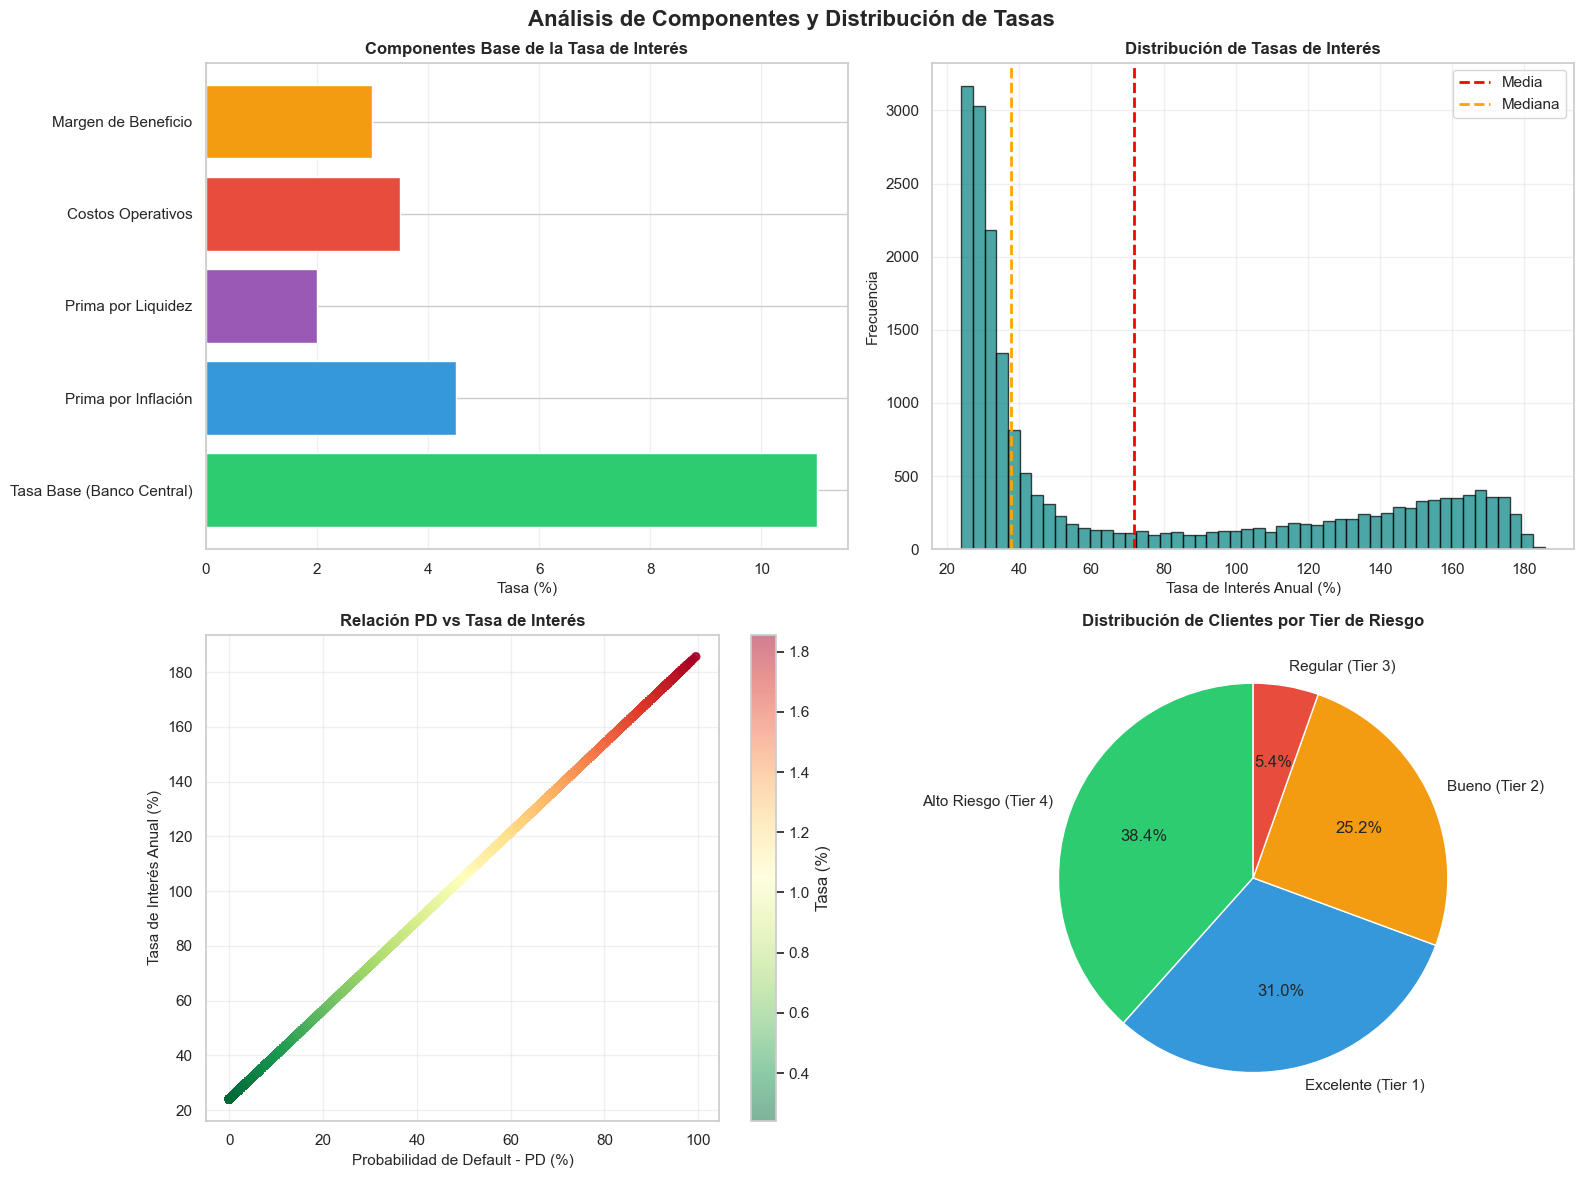

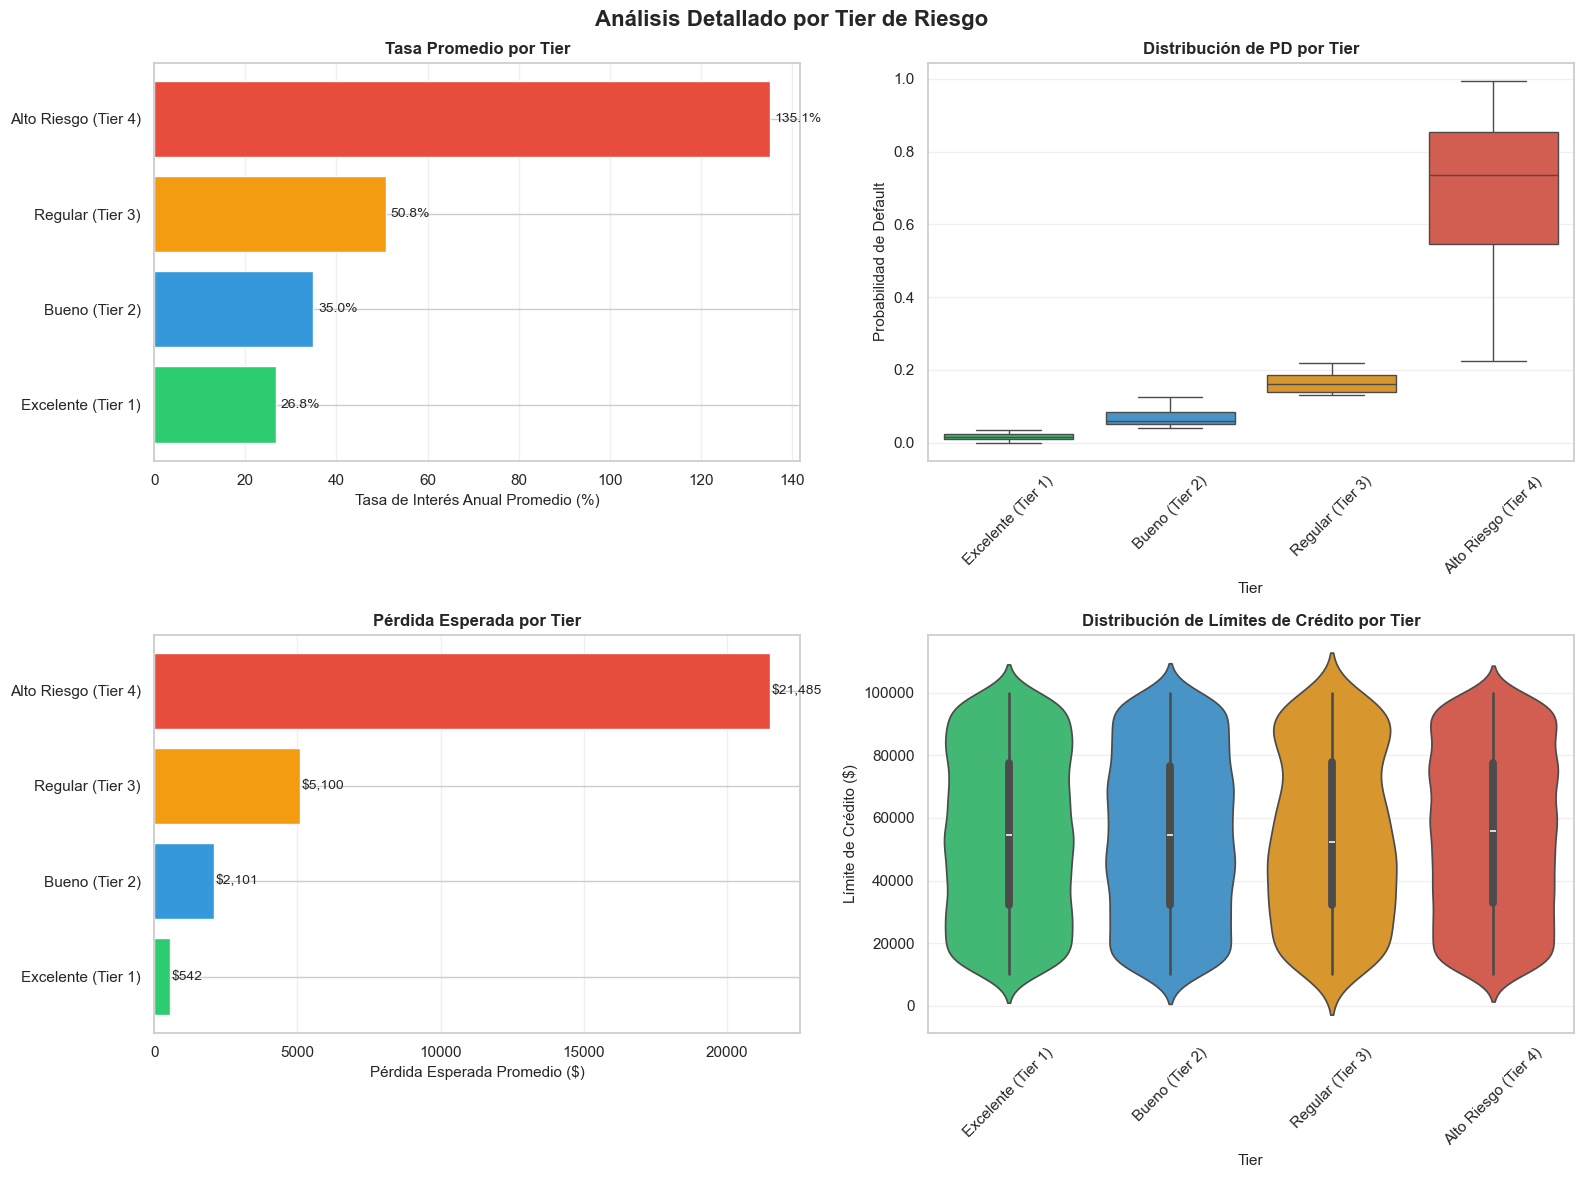

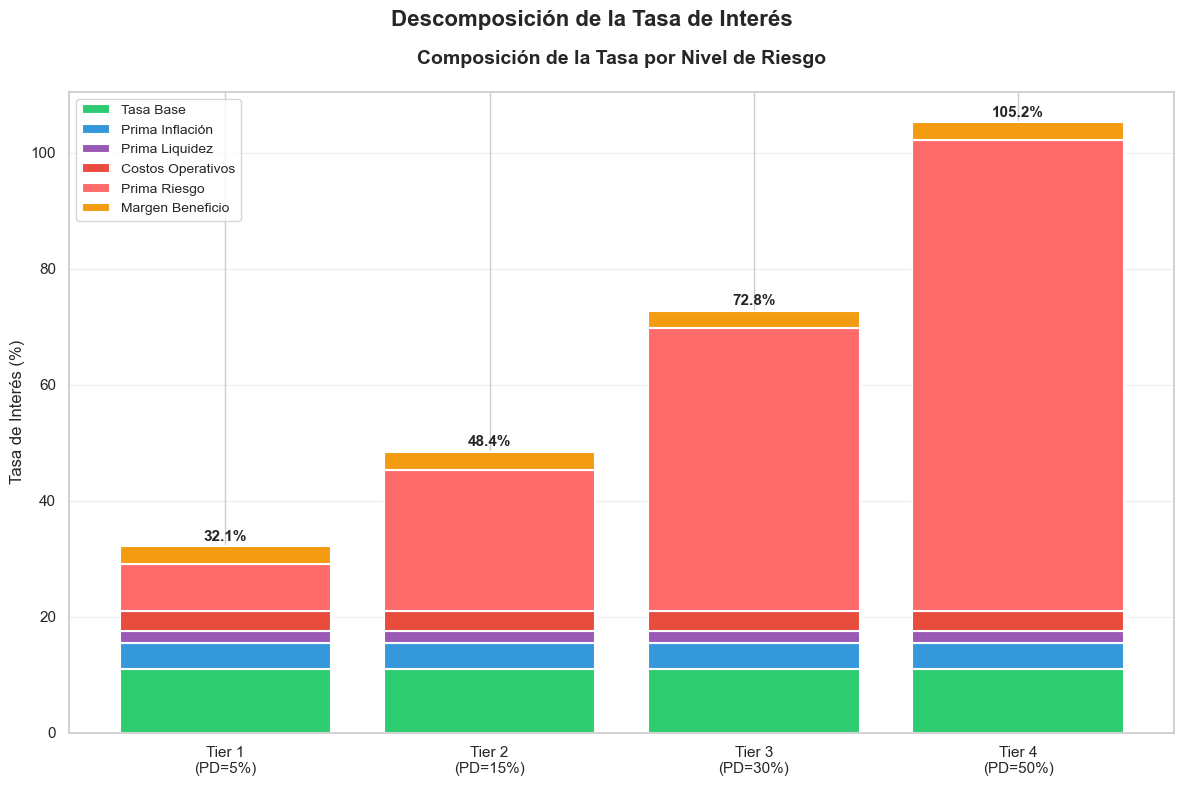

In [15]:
# ===============================================================
# FASE 8: VISUALIZACIONES DE PRICING
# ===============================================================


# ---- FIGURA 1: COMPONENTES Y DISTRIBUCIONES ----
fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
fig1.suptitle('Análisis de Componentes y Distribución de Tasas', fontsize=16, fontweight='bold')

# 1. Componentes de tasa (waterfall)
components_plot = rate_components.display_components()
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', '#34495e']
axes[0, 0].barh(components_plot['Componente'][:-1], 
                 components_plot['Tasa (%)'][:-1], 
                 color=colors)
axes[0, 0].set_xlabel('Tasa (%)', fontsize=11)
axes[0, 0].set_title('Componentes Base de la Tasa de Interés', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Distribución de tasas finales
axes[0, 1].hist(pricing_df['Tasa_Interés_Anual'] * 100, bins=50, 
                color='teal', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(pricing_df['Tasa_Interés_Anual'].mean() * 100, 
                   color='red', linestyle='--', linewidth=2, label='Media')
axes[0, 1].axvline(pricing_df['Tasa_Interés_Anual'].median() * 100, 
                   color='orange', linestyle='--', linewidth=2, label='Mediana')
axes[0, 1].set_xlabel('Tasa de Interés Anual (%)', fontsize=11)
axes[0, 1].set_ylabel('Frecuencia', fontsize=11)
axes[0, 1].set_title('Distribución de Tasas de Interés', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. PD vs Tasa de interés (relación)
scatter = axes[1, 0].scatter(pricing_df['PD'] * 100, 
                            pricing_df['Tasa_Interés_Anual'] * 100,
                            alpha=0.5, c=pricing_df['Tasa_Interés_Anual'], 
                            cmap='RdYlGn_r', s=30)
axes[1, 0].set_xlabel('Probabilidad de Default - PD (%)', fontsize=11)
axes[1, 0].set_ylabel('Tasa de Interés Anual (%)', fontsize=11)
axes[1, 0].set_title('Relación PD vs Tasa de Interés', fontsize=12, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Tasa (%)')

# 4. Distribución por Tier (pie chart)
tier_counts = pricing_df['Tier'].value_counts()
colors_pie = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
axes[1, 1].pie(tier_counts, labels=tier_counts.index, autopct='%1.1f%%',
               colors=colors_pie, startangle=90)
axes[1, 1].set_title('Distribución de Clientes por Tier de Riesgo', 
                     fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ---- FIGURA 2: ANÁLISIS POR TIER ----
fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
fig2.suptitle('Análisis Detallado por Tier de Riesgo', fontsize=16, fontweight='bold')

# 1. Tasas promedio por tier
tier_summary = pricing_df.groupby('Tier')['Tasa_Interés_Anual'].mean().sort_values()
tier_colors = {'Excelente (Tier 1)': '#2ecc71', 'Bueno (Tier 2)': '#3498db', 
               'Regular (Tier 3)': '#f39c12', 'Alto Riesgo (Tier 4)': '#e74c3c'}
colors_bar = [tier_colors.get(t, 'gray') for t in tier_summary.index]

axes[0, 0].barh(range(len(tier_summary)), tier_summary.values * 100, color=colors_bar)
axes[0, 0].set_yticks(range(len(tier_summary)))
axes[0, 0].set_yticklabels(tier_summary.index)
axes[0, 0].set_xlabel('Tasa de Interés Anual Promedio (%)', fontsize=11)
axes[0, 0].set_title('Tasa Promedio por Tier', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

for i, v in enumerate(tier_summary.values * 100):
    axes[0, 0].text(v + 1, i, f'{v:.1f}%', va='center', fontsize=10)

# 2. Boxplot de PD por Tier
tier_order = ['Excelente (Tier 1)', 'Bueno (Tier 2)', 'Regular (Tier 3)', 'Alto Riesgo (Tier 4)']
sns.boxplot(data=pricing_df, x='Tier', y='PD', order=tier_order, 
            palette=tier_colors, ax=axes[0, 1])
axes[0, 1].set_ylabel('Probabilidad de Default', fontsize=11)
axes[0, 1].set_xlabel('Tier', fontsize=11)
axes[0, 1].set_title('Distribución de PD por Tier', fontsize=12, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Pérdida esperada promedio por tier
tier_el = pricing_df.groupby('Tier')['Pérdida_Esperada'].mean().sort_values()
colors_bar_el = [tier_colors.get(t, 'gray') for t in tier_el.index]

axes[1, 0].barh(range(len(tier_el)), tier_el.values, color=colors_bar_el)
axes[1, 0].set_yticks(range(len(tier_el)))
axes[1, 0].set_yticklabels(tier_el.index)
axes[1, 0].set_xlabel('Pérdida Esperada Promedio ($)', fontsize=11)
axes[1, 0].set_title('Pérdida Esperada por Tier', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)

for i, v in enumerate(tier_el.values):
    axes[1, 0].text(v + 50, i, f'${v:,.0f}', va='center', fontsize=10)

# 4. Distribución de límites de crédito por tier
sns.violinplot(data=pricing_df, x='Tier', y='Límite_Crédito', 
               order=tier_order, palette=tier_colors, ax=axes[1, 1])
axes[1, 1].set_ylabel('Límite de Crédito ($)', fontsize=11)
axes[1, 1].set_xlabel('Tier', fontsize=11)
axes[1, 1].set_title('Distribución de Límites de Crédito por Tier', fontsize=12, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ---- FIGURA 3: DESCOMPOSICIÓN DE TASA ----
fig3, ax = plt.subplots(figsize=(12, 8))
fig3.suptitle('Descomposición de la Tasa de Interés', fontsize=16, fontweight='bold')

# Calcular componentes para diferentes niveles de PD
pd_examples = [0.05, 0.15, 0.30, 0.50]
tier_labels = ['Tier 1\n(PD=5%)', 'Tier 2\n(PD=15%)', 'Tier 3\n(PD=30%)', 'Tier 4\n(PD=50%)']

base = rate_components.base_rate
inflation = rate_components.inflation_premium
liquidity = rate_components.liquidity_premium
operational = rate_components.operational_costs
profit = rate_components.profit_margin
lgd = risk_data['lgd']

data_stack = []
for pd in pd_examples:
    risk_premium = pd * lgd * 2.5
    data_stack.append([base, inflation, liquidity, operational, risk_premium, profit])

data_stack = np.array(data_stack).T * 100  # Convertir a porcentajes

# Crear stacked bar chart
bottom = np.zeros(len(pd_examples))
labels = ['Tasa Base', 'Prima Inflación', 'Prima Liquidez', 
          'Costos Operativos', 'Prima Riesgo', 'Margen Beneficio']
colors_stack = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#ff6b6b', '#f39c12']

for i, (row, label, color) in enumerate(zip(data_stack, labels, colors_stack)):
    ax.bar(tier_labels, row, bottom=bottom, label=label, color=color, edgecolor='white', linewidth=1.5)
    bottom += row

ax.set_ylabel('Tasa de Interés (%)', fontsize=12)
ax.set_title('Composición de la Tasa por Nivel de Riesgo', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Añadir totales encima de cada barra
totals = bottom
for i, (label, total) in enumerate(zip(tier_labels, totals)):
    ax.text(i, total + 1, f'{total:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


In [16]:
# ===============================================================
# FASE 9: REPORTE FINAL Y TABLA RESUMEN
# ===============================================================

# Tabla resumen por tier
print("\n   TABLA RESUMEN: MÉTRICAS POR TIER")
print("   " + "="*90)

tier_full_summary = pricing_df.groupby('Tier').agg({
    'Tasa_Interés_Anual': ['mean', 'std'],
    'PD': 'mean',
    'Pérdida_Esperada': 'mean',
    'Límite_Crédito': 'mean',
    'Cliente_ID': 'count'
}).round(4)

tier_full_summary.columns = ['Tasa Media', 'Tasa Std', 'PD Media', 'EL Media', 'Límite Medio', 'N° Clientes']

# Formatear para mejor visualización
tier_display = tier_full_summary.copy()
tier_display['Tasa Media'] = tier_display['Tasa Media'].apply(lambda x: f"{x:.2%}")
tier_display['Tasa Std'] = tier_display['Tasa Std'].apply(lambda x: f"{x:.2%}")
tier_display['PD Media'] = tier_display['PD Media'].apply(lambda x: f"{x:.2%}")
tier_display['EL Media'] = tier_display['EL Media'].apply(lambda x: f"${x:,.0f}")
tier_display['Límite Medio'] = tier_display['Límite Medio'].apply(lambda x: f"${x:,.0f}")

print(tier_display.to_string())
print("   " + "="*90)

# Ejemplo de clientes individuales
print("\n   EJEMPLO: 10 CLIENTES CON SUS TASAS PERSONALIZADAS")
print("   " + "="*100)

sample_df = pricing_df.sample(10, random_state=42)[
    ['Cliente_ID', 'PD', 'Prima_Riesgo', 'Tasa_Interés_Anual', 'Tasa_Mensual', 'Límite_Crédito', 'Tier']
].copy()

sample_df['PD'] = sample_df['PD'].apply(lambda x: f"{x:.2%}")
sample_df['Prima_Riesgo'] = sample_df['Prima_Riesgo'].apply(lambda x: f"{x:.2%}")
sample_df['Tasa_Interés_Anual'] = sample_df['Tasa_Interés_Anual'].apply(lambda x: f"{x:.2%}")
sample_df['Tasa_Mensual'] = sample_df['Tasa_Mensual'].apply(lambda x: f"{x:.2%}")
sample_df['Límite_Crédito'] = sample_df['Límite_Crédito'].apply(lambda x: f"${x:,.0f}")

print(sample_df.to_string(index=False))
print("   " + "="*100)

# Resumen ejecutivo
print("\n   RESUMEN EJECUTIVO DEL MODELO")
print("   " + "="*80)
print(f"\n   DATOS PROCESADOS:")
print(f"   • Total de clientes analizados: {len(pricing_df):,}")
print(f"   • Variables predictoras: {X.shape[1]}")
print(f"   • Modelo seleccionado: Random Forest Optimizado")
print(f"   • AUC-ROC del modelo: {auc_best:.4f}")

print(f"\n   COMPONENTES DE TASA:")
print(f"   • Tasa base + componentes fijos: {rate_components.get_base_components_rate():.2%}")
print(f"   • Prima de riesgo (variable): {pricing_df['Prima_Riesgo'].min():.2%} - {pricing_df['Prima_Riesgo'].max():.2%}")

print(f"\n   PARÁMETROS DE RIESGO:")
print(f"   • PD Promedio: {risk_data['pd_portfolio']:.2%}")
print(f"   • LGD: {risk_data['lgd']:.2%}")
print(f"   • Pérdida Esperada Total: ${np.sum(risk_data['el_values']):,.0f}")

print(f"\n   TASAS FINALES:")
print(f"   • Rango de tasas: {pricing_df['Tasa_Interés_Anual'].min():.2%} - {pricing_df['Tasa_Interés_Anual'].max():.2%}")
print(f"   • Tasa promedio: {pricing_df['Tasa_Interés_Anual'].mean():.2%}")
print(f"   • Tasa mediana: {pricing_df['Tasa_Interés_Anual'].median():.2%}")

print(f"\n   DISTRIBUCIÓN POR TIER:")
for tier in ['Excelente (Tier 1)', 'Bueno (Tier 2)', 'Regular (Tier 3)', 'Alto Riesgo (Tier 4)']:
    if tier in tier_dist.index:
        count = tier_dist[tier]
        pct = count / len(pricing_df) * 100
        avg_rate = pricing_df[pricing_df['Tier'] == tier]['Tasa_Interés_Anual'].mean()
        print(f"   • {tier}: {count} clientes ({pct:.1f}%) - Tasa promedio: {avg_rate:.2%}")

print("\n   " + "="*80)


   TABLA RESUMEN: MÉTRICAS POR TIER
                     Tasa Media Tasa Std PD Media EL Media Límite Medio  N° Clientes
Tier                                                                                
Alto Riesgo (Tier 4)    135.07%   33.21%   68.35%  $21,485      $55,303         7679
Bueno (Tier 2)           34.95%    3.78%    6.74%   $2,101      $54,658         5042
Excelente (Tier 1)       26.83%    1.77%    1.74%     $542      $54,856         6195
Regular (Tier 3)         50.84%    4.33%   16.52%   $5,100      $54,175         1084

   EJEMPLO: 10 CLIENTES CON SUS TASAS PERSONALIZADAS
 Cliente_ID     PD Prima_Riesgo Tasa_Interés_Anual Tasa_Mensual Límite_Crédito                 Tier
      10651  4.50%        7.31%             31.31%        2.61%        $94,302       Bueno (Tier 2)
       2042 89.00%      144.62%            168.62%       14.05%        $60,510 Alto Riesgo (Tier 4)
       8669 14.50%       23.56%             47.56%        3.96%        $32,700     Regular (Tier 3)